In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn import  linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
%matplotlib inline

In [ ]:
malware=pd.read_csv('/content/drive/My Drive/malware-detection-va/train.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
malware

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,6ca9b92a49d4d23fc4754d464155cbb1,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1516.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,154,108573.0,27.0,240.0,233,windows10,x86,10.0.0.0,17134,256,rs4,17134.1.x86fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,1980.0,317708.0,2.0,5.0,...,HDD,476043.0,0,4096.0,Desktop,15.7,1280.0,800.0,Desktop,NaN,4.294967e+09,10.0.17134.228,x86,rs4_release,17134,228,Professional,PROFESSIONAL,Upgrade,9.0,34,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,33778.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,640b82f0a7bd3701818b9442d1432937,win8defender,1.1.15200.1,4.18.1807.18075,1.275.727.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,39,64466.0,NaN,15.0,58,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,1915.0,225063.0,4.0,5.0,...,SSD,237673.0,0,8192.0,Desktop,65.0,1920.0,1080.0,Mobile,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,Reset,8.0,31,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,33778.0,0,NaN,0.0,0,0,0.0,0.0,15.0,0
2,cf34b73e0b66f6dd249c3b7dff1fb7dd,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1587.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,81,56441.0,18.0,277.0,75,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,0.0,111.0,Off,1.0,1.0,Convertible,Windows.Desktop,1443.0,256628.0,8.0,5.0,...,SSD,231113.0,0,8192.0,Notebook,13.2,1920.0,1080.0,Mobile,NaN,0.000000e+00,10.0.16299.192,amd64,rs3_release,16299,192,Core,CORE,Other,8.0,31,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,7360.0,1,NaN,0.0,1,0,0.0,0.0,10.0,1
3,6b59109284f680df09295d51e72e7abf,win8defender,1.1.15200.1,4.18.1807.18075,1.275.461.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,220,24282.0,27.0,237.0,72,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1443.0,256586.0,4.0,5.0,...,HDD,953253.0,0,8192.0,Portable,15.3,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.17134.228,amd64,rs4_release,17134,228,CoreSingleLanguage,CORE_SINGLELANGUAGE,IBSClean,8.0,31,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,355.0,19956.0,1,NaN,0.0,0,0,0.0,0.0,11.0,0
4,d1e4f6460d095127de936210ab587e3c,win8defen

In [ ]:
malware.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567730 entries, 0 to 567729
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  567730 non-null  object 
 1   ProductName                                        567730 non-null  object 
 2   EngineVersion                                      567730 non-null  object 
 3   AppVersion                                         567730 non-null  object 
 4   AvSigVersion                                       567730 non-null  object 
 5   IsBeta                                             567730 non-null  int64  
 6   RtpStateBitfield                                   565468 non-null  float64
 7   IsSxsPassiveMode                                   567730 non-null  int64  
 8   DefaultBrowsersIdentifier                          29487 non-null   float6

In [ ]:
missing=malware.isnull().sum()*100/len(malware)
print(missing[missing>50])

DefaultBrowsersIdentifier     94.806158
PuaMode                       99.982738
Census_ProcessorClass         99.624469
Census_InternalBatteryType    70.497243
Census_IsFlightingInternal    82.783189
Census_ThresholdOptIn         63.114156
Census_IsWIMBootEnabled       63.021859
dtype: float64


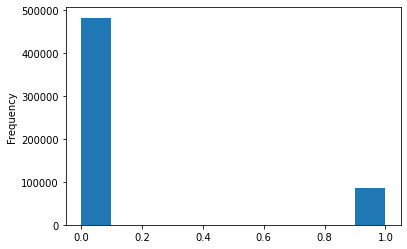

In [ ]:
target=malware['HasDetections']
target.plot.hist()

In [ ]:
malware.drop(['DefaultBrowsersIdentifier','MachineIdentifier','PuaMode','Census_ProcessorClass','Census_InternalBatteryType','Census_IsFlightingInternal','Census_ThresholdOptIn',
'Census_IsWIMBootEnabled'],axis=1,inplace=True)

In [ ]:
def selectbytype(df,type):  
 return df.select_dtypes(include=type)

In [ ]:
def frequencyencoding(df,cols):
  for col in cols:   
    newcol=col
    df[newcol]=df.groupby(col)[col].transform('count')
    df[newcol]=(df[newcol]-df[newcol].min())/(df[newcol].max()-df[newcol].min())
  return(df)

In [ ]:
categorical=selectbytype(malware,'object')
categorical

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1516.0,windows10,x86,10.0.0.0,rs4,17134.1.x86fre.rs4_release.180410-1804,Pro,NaN,Desktop,Windows.Desktop,HDD,Desktop,Desktop,10.0.17134.228,x86,rs4_release,Professional,PROFESSIONAL,Upgrade,FullAuto,IS_GENUINE,Retail,Retail
1,win8defender,1.1.15200.1,4.18.1807.18075,1.275.727.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,Desktop,Windows.Desktop,SSD,Desktop,Mobile,10.0.17134.228,amd64,rs4_release,Professional,PROFESSIONAL,Reset,FullAuto,IS_GENUINE,Retail,Retail
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1587.0,windows10,x64,10.0.0.0,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,Off,Convertible,Windows.Desktop,SSD,Notebook,Mobile,10.0.16299.192,amd64,rs3_release,Core,CORE,Other,UNKNOWN,IS_GENUINE,OEM:DM,Retail
3,win8defender,1.1.15200.1,4.18.1807.18075,1.275.461.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,Notebook,Windows.Desktop,HDD,Portable,Mobile,10.0.17134.228,amd64,rs4_release,CoreSingleLanguage,CORE_SINGLELANGUAGE,IBSClean,FullAuto,IS_GENUINE,Retail,Retail
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1420.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,RequireAdmin,Desktop,Windows.Desktop,HDD,Desktop,Desktop,10.0.17134.112,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,Notify,IS_GENUINE,Retail,Retail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,windows10,x64,10.0.0.0,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,RequireAdmin,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.16299.431,amd64,rs3_release_svc_escrow,Core,CORE,Upgrade,Notify,IS_GENUINE,OEM:DM,Retail
567726,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1005.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.17134.191,amd64,rs4_release,Core,CORE,Reset,FullAuto,IS_GENUINE,Retail,Retail
567727,win8defender,1.1.14901.4,4.16.17656.18052,1.269.1961.0,windows10,x64,10.0.0.0,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,NaN,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.16299.431,amd64,rs3_release_svc_escrow,Core,CORE,UUPUpgrade,UNKNOWN,IS_GENUINE,OEM:DM,Retail
567728,win8defender,1.1.15200.1,4.12.17007.18022,1.275.1140.0,windows10,x64,10.0.0.0,rs1,14393.2068.amd64fre.rs1_release.180209-1727,Home,RequireAdmin,Detachable,Windows.Desktop,SSD,UNKNOWN,Slate,10.0.14393.2068,amd64,rs1_release,Core,CORE,Other,UNKNOWN,IS_GENUINE,OEM:DM,Retail


In [ ]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567730 entries, 0 to 567729
Data columns (total 26 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   ProductName                       567730 non-null  object
 1   EngineVersion                     567730 non-null  object
 2   AppVersion                        567730 non-null  object
 3   AvSigVersion                      567730 non-null  object
 4   Platform                          567730 non-null  object
 5   Processor                         567730 non-null  object
 6   OsVer                             567730 non-null  object
 7   OsPlatformSubRelease              567730 non-null  object
 8   OsBuildLab                        567729 non-null  object
 9   SkuEdition                        567730 non-null  object
 10  SmartScreen                       360513 non-null  object
 11  Census_MDC2FormFactor             567730 non-null  object
 12  Ce

In [ ]:
def labelencode(df,cols):
 for col in cols:
   df[col]=df[col].astype('category').values.codes
 return df

In [ ]:
def scale(df,cols):
  for col in cols:
    if len(df[col].value_counts())>2:
      df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())
  return df

In [ ]:
categoricalnew=labelencode(categorical.copy(),categorical.columns)
categoricalfreq=frequencyencoding(categoricalnew.copy(),categoricalnew.columns)

In [ ]:
categoricalfreq

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
0,1.0,0.872745,1.000000,0.076301,1.0,0.119096,1.0,1.000000,0.084494,0.567084,0.692477,0.330492,1.0,1.000000,0.343792,0.322611,1.000000,0.118921,1.000000,0.851860,0.866625,0.503256,1.000000,1.0,1.000000,1.0
1,1.0,1.000000,1.000000,0.898825,1.0,1.000000,1.0,1.000000,1.000000,0.567084,0.692477,0.330492,1.0,0.427967,0.343792,1.000000,1.000000,1.000000,1.000000,0.851860,0.866625,0.247053,1.000000,1.0,1.000000,1.0
2,1.0,0.872745,1.000000,0.029757,1.0,1.000000,1.0,0.663150,0.276796,1.000000,0.039697,0.071129,1.0,0.427967,1.000000,1.000000,0.073195,1.000000,0.332666,1.000000,1.000000,0.328599,0.654341,1.0,0.719103,1.0
3,1.0,1.000000,1.000000,0.055547,1.0,1.000000,1.0,1.000000,1.000000,1.000000,0.692477,1.000000,1.0,1.000000,0.070943,1.000000,1.000000,1.000000,1.000000,0.515752,0.515667,0.625204,1.000000,1.0,1.000000,1.0
4,1.0,0.872745,1.000000,0.922020,1.0,1.000000,1.0,1.000000,1.000000,0.567084,1.000000,0.330492,1.0,1.000000,0.343792,0.322611,0.259546,1.000000,1.000000,0.851860,0.866625,1.000000,0.541008,1.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,1.0,0.872745,1.000000,0.161148,1.0,1.000000,1.0,0.663150,0.349338,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.410628,1.000000,0.302115,1.000000,1.000000,0.503256,0.541008,1.0,0.719103,1.0
567726,1.0,0.872745,1.000000,0.454296,1.0,1.000000,1.0,1.000000,1.000000,1.000000,0.692477,1.000000,1.0,1.000000,1.000000,1.000000,0.173736,1.000000,1.000000,1.000000,1.000000,0.247053,1.000000,1.0,1.000000,1.0
567727,1.0,0.069217,0.058834,0.025332,1.0,1.000000,1.0,0.663150,0.349338,1.000000,0.692477,1.000000,1.0,1.000000,1.000000,1.000000,0.410628,1.000000,0.302115,1.000000,1.000000,1.000000,0.654341,1.0,0.719103,1.0
567728,1.0,1.000000,0.026961,0.982909,1.0,1.000000,1.0,0.198205,0.004751,1.000000,1.000000,0.061135,1.0,0.427967,0.013682,0.094813,0.015376,1.000000,0.213122,1.000000,1.000000,0.328599,0.654341,1.0,0.719103,1.0


In [ ]:
intdata=malware.select_dtypes(include='int64')
intdata

,IsBeta,IsSxsPassiveMode,HasTpm,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,AutoSampleOptIn,Census_HasOpticalDiskDrive,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,HasDetections
0,0,0,1,154,233,17134,256,0,0,17134,228,34,0,0,0,0,0
1,0,0,1,39,58,17134,256,0,0,17134,228,31,0,0,0,0,0
2,0,0,1,81,75,16299,768,0,0,16299,192,31,0,1,1,0,1
3,0,0,1,220,72,17134,768,0,0,17134,228,31,0,1,0,0,0
4,0,0,1,51,103,17134,256,0,0,17134,112,26,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,0,0,1,160,170,16299,768,0,0,16299,431,115,0,1,0,0,0
567726,0,0,1,35,60,17134,768,0,0,17134,191,30,0,1,0,0,0
567727,0,0,1,160,56,16299,768,0,0,16299,431,109,0,1,0,0,1
567728,0,0,1,97,124,14393,768,0,0,14393,2068,72,0,1,1,0,1


In [ ]:
intdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567730 entries, 0 to 567729
Data columns (total 17 columns):
 #   Column                            Non-Null Count   Dtype
---  ------                            --------------   -----
 0   IsBeta                            567730 non-null  int64
 1   IsSxsPassiveMode                  567730 non-null  int64
 2   HasTpm                            567730 non-null  int64
 3   CountryIdentifier                 567730 non-null  int64
 4   LocaleEnglishNameIdentifier       567730 non-null  int64
 5   OsBuild                           567730 non-null  int64
 6   OsSuite                           567730 non-null  int64
 7   AutoSampleOptIn                   567730 non-null  int64
 8   Census_HasOpticalDiskDrive        567730 non-null  int64
 9   Census_OSBuildNumber              567730 non-null  int64
 10  Census_OSBuildRevision            567730 non-null  int64
 11  Census_OSUILocaleIdentifier       567730 non-null  int64
 12  Census_IsPortabl

IsBeta
0    15.000044
1     0.000000
Name: HasDetections, dtype: float64
IsBeta
0    99.999119
1     0.000881
Name: HasDetections, dtype: float64


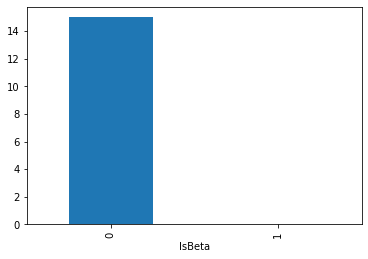

IsSxsPassiveMode
0    15.120334
1     9.252425
Name: HasDetections, dtype: float64
IsSxsPassiveMode
0    97.947792
1     2.052208
Name: HasDetections, dtype: float64


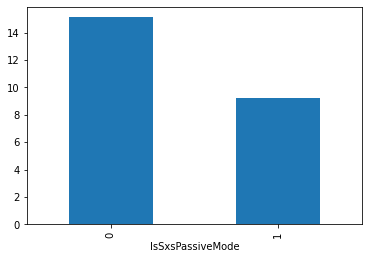

HasTpm
0    13.404711
1    15.019840
Name: HasDetections, dtype: float64
HasTpm
0     1.233861
1    98.766139
Name: HasDetections, dtype: float64


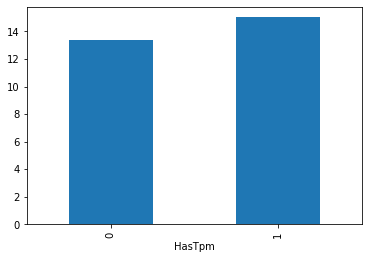

CountryIdentifier
1      13.821138
2      12.844244
3      16.053512
4      13.095238
5      17.647059
         ...    
218    21.052632
219     8.000000
220    13.350449
221    11.494253
222    16.300578
Name: HasDetections, Length: 222, dtype: float64
CountryIdentifier
1      0.021665
2      0.780300
3      0.052666
4      0.029592
5      0.008983
         ...   
218    0.030120
219    0.030825
220    0.960492
221    0.107269
222    0.152361
Name: HasDetections, Length: 222, dtype: float64


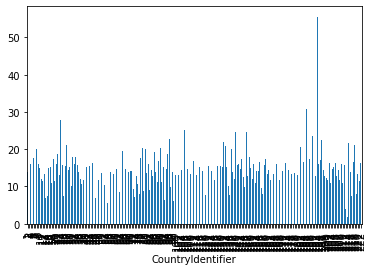

LocaleEnglishNameIdentifier
1       8.333333
2      13.461538
3       0.000000
4      11.111111
5       9.756098
         ...    
277    14.675221
278     0.000000
280     0.000000
282    11.111111
283    23.529412
Name: HasDetections, Length: 238, dtype: float64
LocaleEnglishNameIdentifier
1      0.004227
2      0.009159
3      0.001409
4      0.001585
5      0.014443
         ...   
277    0.219647
278    0.001233
280    0.000528
282    0.001585
283    0.002994
Name: HasDetections, Length: 238, dtype: float64


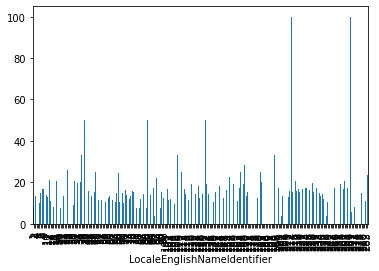

OsBuild
7600      11.111111
7601      14.085213
9600      15.702752
10240     14.488458
10586     13.326573
14393     12.976711
15063     13.922106
16299     14.612269
17133      0.000000
17134     16.130379
17604      0.000000
17618    100.000000
17627      0.000000
17634      0.000000
17639      0.000000
17643      0.000000
17650      0.000000
17655      0.000000
17661     50.000000
17666      6.250000
17672      8.333333
17677     13.636364
17682     13.333333
17686      5.714286
17689      0.000000
17692     12.227074
17704      9.090909
17711      0.000000
17713      1.234568
17723      0.000000
17728      0.000000
17730      0.000000
17733     14.634146
17735     15.686275
17738     16.568047
17741     10.169492
17744     10.256410
17746     13.580247
17747      0.000000
17751     12.195122
17753      0.000000
17754     18.181818
17755     11.764706
17758     12.359551
17760      8.474576
17761      0.000000
17763     11.627907
18204    100.000000
18219      0.000000
18234     25

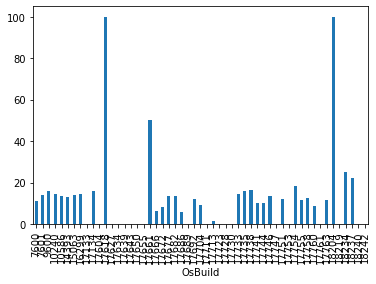

OsSuite
16     16.216216
144    50.000000
256    15.663585
272     8.407080
274    25.000000
305     7.317073
400    10.000000
768    14.630840
784     0.000000
Name: HasDetections, dtype: float64
OsSuite
16      0.006517
144     0.000352
256    36.790904
272     0.159231
274     0.000705
305     0.007222
400     0.010568
768    63.022740
784     0.001761
Name: HasDetections, dtype: float64


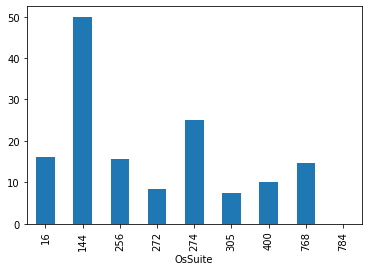

AutoSampleOptIn
0    14.999903
1    15.384615
Name: HasDetections, dtype: float64
AutoSampleOptIn
0    99.99771
1     0.00229
Name: HasDetections, dtype: float64


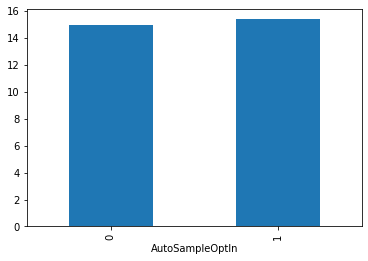

Census_HasOpticalDiskDrive
0    14.823164
1    17.235659
Name: HasDetections, dtype: float64
Census_HasOpticalDiskDrive
0    92.67363
1     7.32637
Name: HasDetections, dtype: float64


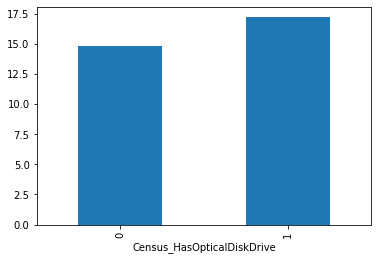

Census_OSBuildNumber
9200       0.000000
10240     14.520703
10565    100.000000
10576      0.000000
10586     13.732278
            ...    
18219      0.000000
18234     31.250000
18237     20.000000
18240      0.000000
18242      0.000000
Name: HasDetections, Length: 72, dtype: float64
Census_OSBuildNumber
9200     0.000176
10240    3.105349
10565    0.000176
10576    0.000176
10586    6.920015
           ...   
18219    0.000176
18234    0.002818
18237    0.001761
18240    0.000176
18242    0.000881
Name: HasDetections, Length: 72, dtype: float64


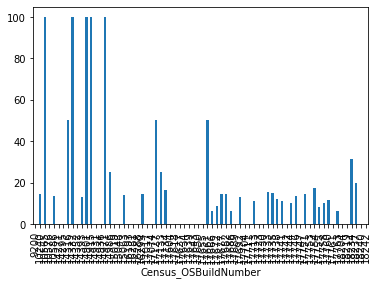

Census_OSBuildRevision
0         15.160294
1         16.195063
3         16.945107
4         14.634146
5         12.181818
            ...    
17918     28.000000
17946     24.102564
17974      0.000000
17976     19.354839
41736    100.000000
Name: HasDetections, Length: 241, dtype: float64
Census_OSBuildRevision
0        1.824107
1        1.170275
3        0.073803
4        0.007222
5        0.096877
           ...   
17918    0.004404
17946    0.034347
17974    0.000176
17976    0.010921
41736    0.000176
Name: HasDetections, Length: 241, dtype: float64


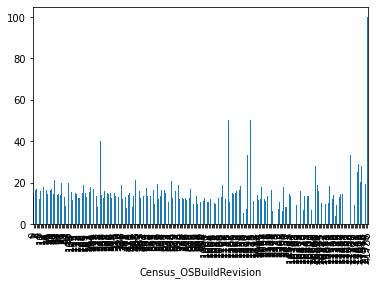

Census_OSUILocaleIdentifier
5      13.240549
6       0.000000
7       0.000000
9       0.000000
11     21.388368
         ...    
158    15.893749
159    12.765957
160    14.949416
161    33.333333
162    28.571429
Name: HasDetections, Length: 100, dtype: float64
Census_OSUILocaleIdentifier
5      0.936537
6      0.000528
7      0.000705
9      0.000176
11     0.187765
         ...   
158    4.409667
159    0.049671
160    2.263400
161    0.001057
162    0.001233
Name: HasDetections, Length: 100, dtype: float64


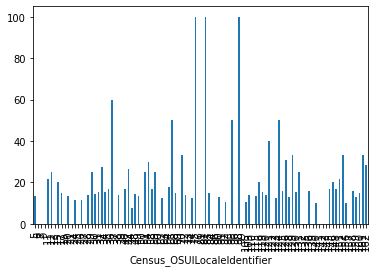

Census_IsPortableOperatingSystem
0    14.999727
1    15.358362
Name: HasDetections, dtype: float64
Census_IsPortableOperatingSystem
0    99.948391
1     0.051609
Name: HasDetections, dtype: float64


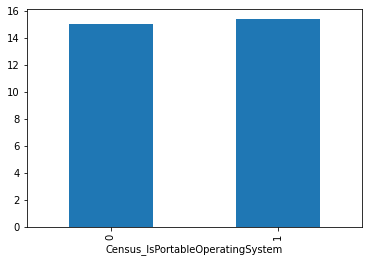

Census_IsSecureBootEnabled
0    15.010933
1    14.988296
Name: HasDetections, dtype: float64
Census_IsSecureBootEnabled
0    51.3133
1    48.6867
Name: HasDetections, dtype: float64


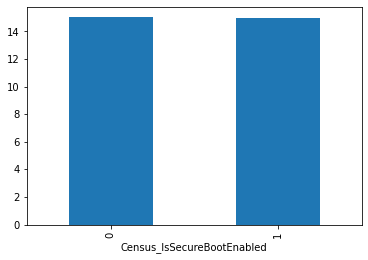

Census_IsTouchEnabled
0    15.392174
1    12.470150
Name: HasDetections, dtype: float64
Census_IsTouchEnabled
0    86.575661
1    13.424339
Name: HasDetections, dtype: float64


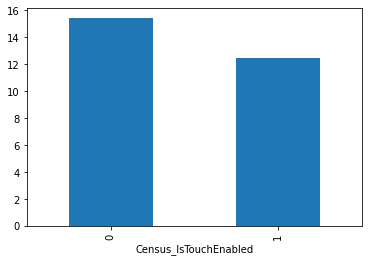

Census_IsPenCapable
0    15.103982
1    12.532103
Name: HasDetections, dtype: float64
Census_IsPenCapable
0    95.953534
1     4.046466
Name: HasDetections, dtype: float64


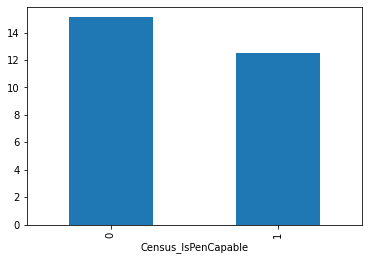

HasDetections
0      0.0
1    100.0
Name: HasDetections, dtype: float64
HasDetections
0    85.000088
1    14.999912
Name: HasDetections, dtype: float64


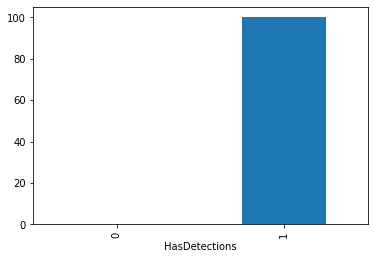

In [ ]:
x=0
for cols in intdata:
  plt.figure(x)
  count=malware.groupby(cols)['HasDetections'].count()
  sum=malware.groupby(cols)['HasDetections'].sum()
  ((sum/count)*100).plot.bar()
  print(sum*100/count)
  print(count*100/len(malware))
  plt.show()

In [ ]:
intdata=scale(intdata.copy(),intdata.columns)
intdata

,IsBeta,IsSxsPassiveMode,HasTpm,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,AutoSampleOptIn,Census_HasOpticalDiskDrive,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,HasDetections
0,0,0,1,0.692308,0.822695,0.895884,0.312500,0,0,0.877461,0.005463,0.184713,0,0,0,0,0
1,0,0,1,0.171946,0.202128,0.895884,0.312500,0,0,0.877461,0.005463,0.165605,0,0,0,0,0
2,0,0,1,0.361991,0.262411,0.817422,0.979167,0,0,0.785114,0.004600,0.165605,0,1,1,0,1
3,0,0,1,0.990950,0.251773,0.895884,0.979167,0,0,0.877461,0.005463,0.165605,0,1,0,0,0
4,0,0,1,0.226244,0.361702,0.895884,0.312500,0,0,0.877461,0.002684,0.133758,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,0,0,1,0.719457,0.599291,0.817422,0.979167,0,0,0.785114,0.010327,0.700637,0,1,0,0,0
567726,0,0,1,0.153846,0.209220,0.895884,0.979167,0,0,0.877461,0.004576,0.159236,0,1,0,0,0
567727,0,0,1,0.719457,0.195035,0.817422,0.979167,0,0,0.785114,0.010327,0.662420,0,1,0,0,1
567728,0,0,1,0.434389,0.436170,0.638320,0.979167,0,0,0.574320,0.049550,0.426752,0,1,1,0,1


In [ ]:
floatdata=malware.select_dtypes(include='float64')
floatdata

,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSInstallLanguageIdentifier,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,7.0,53447.0,1.0,1.0,108573.0,27.0,240.0,1.0,0.0,137.0,1.0,1.0,1980.0,317708.0,2.0,5.0,3439.0,476940.0,476043.0,4096.0,15.7,1280.0,800.0,4.294967e+09,9.0,0.0,142.0,33778.0,0.0,0.0,0.0,10.0
1,7.0,53447.0,1.0,1.0,64466.0,NaN,15.0,1.0,0.0,137.0,1.0,1.0,1915.0,225063.0,4.0,5.0,2640.0,238475.0,237673.0,8192.0,65.0,1920.0,1080.0,4.294967e+09,8.0,0.0,142.0,33778.0,0.0,0.0,0.0,15.0
2,7.0,53447.0,1.0,1.0,56441.0,18.0,277.0,1.0,0.0,111.0,1.0,1.0,1443.0,256628.0,8.0,5.0,2737.0,244198.0,231113.0,8192.0,13.2,1920.0,1080.0,0.000000e+00,8.0,0.0,355.0,7360.0,0.0,0.0,0.0,10.0
3,7.0,53447.0,1.0,1.0,24282.0,27.0,237.0,1.0,0.0,137.0,1.0,1.0,1443.0,256586.0,4.0,5.0,2998.0,953869.0,953253.0,8192.0,15.3,1366.0,768.0,0.000000e+00,8.0,0.0,355.0,19956.0,0.0,0.0,0.0,11.0
4,7.0,53447.0,1.0,1.0,8750.0,27.0,98.0,1.0,0.0,137.0,1.0,1.0,4589.0,313586.0,6.0,1.0,837.0,610480.0,609928.0,8192.0,21.5,1920.0,1080.0,4.294967e+09,5.0,0.0,142.0,7672.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567725,7.0,47238.0,2.0,1.0,159247.0,27.0,204.0,1.0,0.0,117.0,1.0,1.0,2668.0,171320.0,2.0,5.0,1998.0,476940.0,431085.0,4096.0,15.5,1366.0,768.0,0.000000e+00,25.0,0.0,628.0,8789.0,0.0,0.0,0.0,3.0
567726,7.0,53447.0,1.0,1.0,119475.0,27.0,45.0,1.0,0.0,137.0,1.0,1.0,585.0,189480.0,4.0,1.0,142.0,953869.0,953302.0,6144.0,17.2,1600.0,900.0,0.000000e+00,7.0,0.0,556.0,63122.0,0.0,0.0,0.0,4.0
567727,7.0,49480.0,2.0,1.0,67457.0,18.0,181.0,1.0,0.0,117.0,1.0,1.0,585.0,189551.0,2.0,5.0,2097.0,953869.0,952727.0,4096.0,15.5,1366.0,768.0,0.000000e+00,24.0,0.0,556.0,63317.0,0.0,0.0,1.0,3.0
567728,7.0,53447.0,1.0,1.0,93324.0,27.0,126.0,1.0,0.0,98.0,1.0,1.0,585.0,313561.0,4.0,5.0,1916.0,59640.0,58498.0,4096.0,15.7,1280.0,800.0,1.000000e+01,18.0,0.0,142.0,6613.0,0.0,1.0,0.0,15.0


In [ ]:
floatdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567730 entries, 0 to 567729
Data columns (total 32 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   RtpStateBitfield                                   565468 non-null  float64
 1   AVProductStatesIdentifier                          565103 non-null  float64
 2   AVProductsInstalled                                565103 non-null  float64
 3   AVProductsEnabled                                  565103 non-null  float64
 4   CityIdentifier                                     546792 non-null  float64
 5   OrganizationIdentifier                             392865 non-null  float64
 6   GeoNameIdentifier                                  567717 non-null  float64
 7   IsProtected                                        565116 non-null  float64
 8   SMode                                              529368 non-null  float6

In [ ]:
floatdata.fillna(floatdata.mean(),inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
floatdata=scale(floatdata.copy(),floatdata.columns)

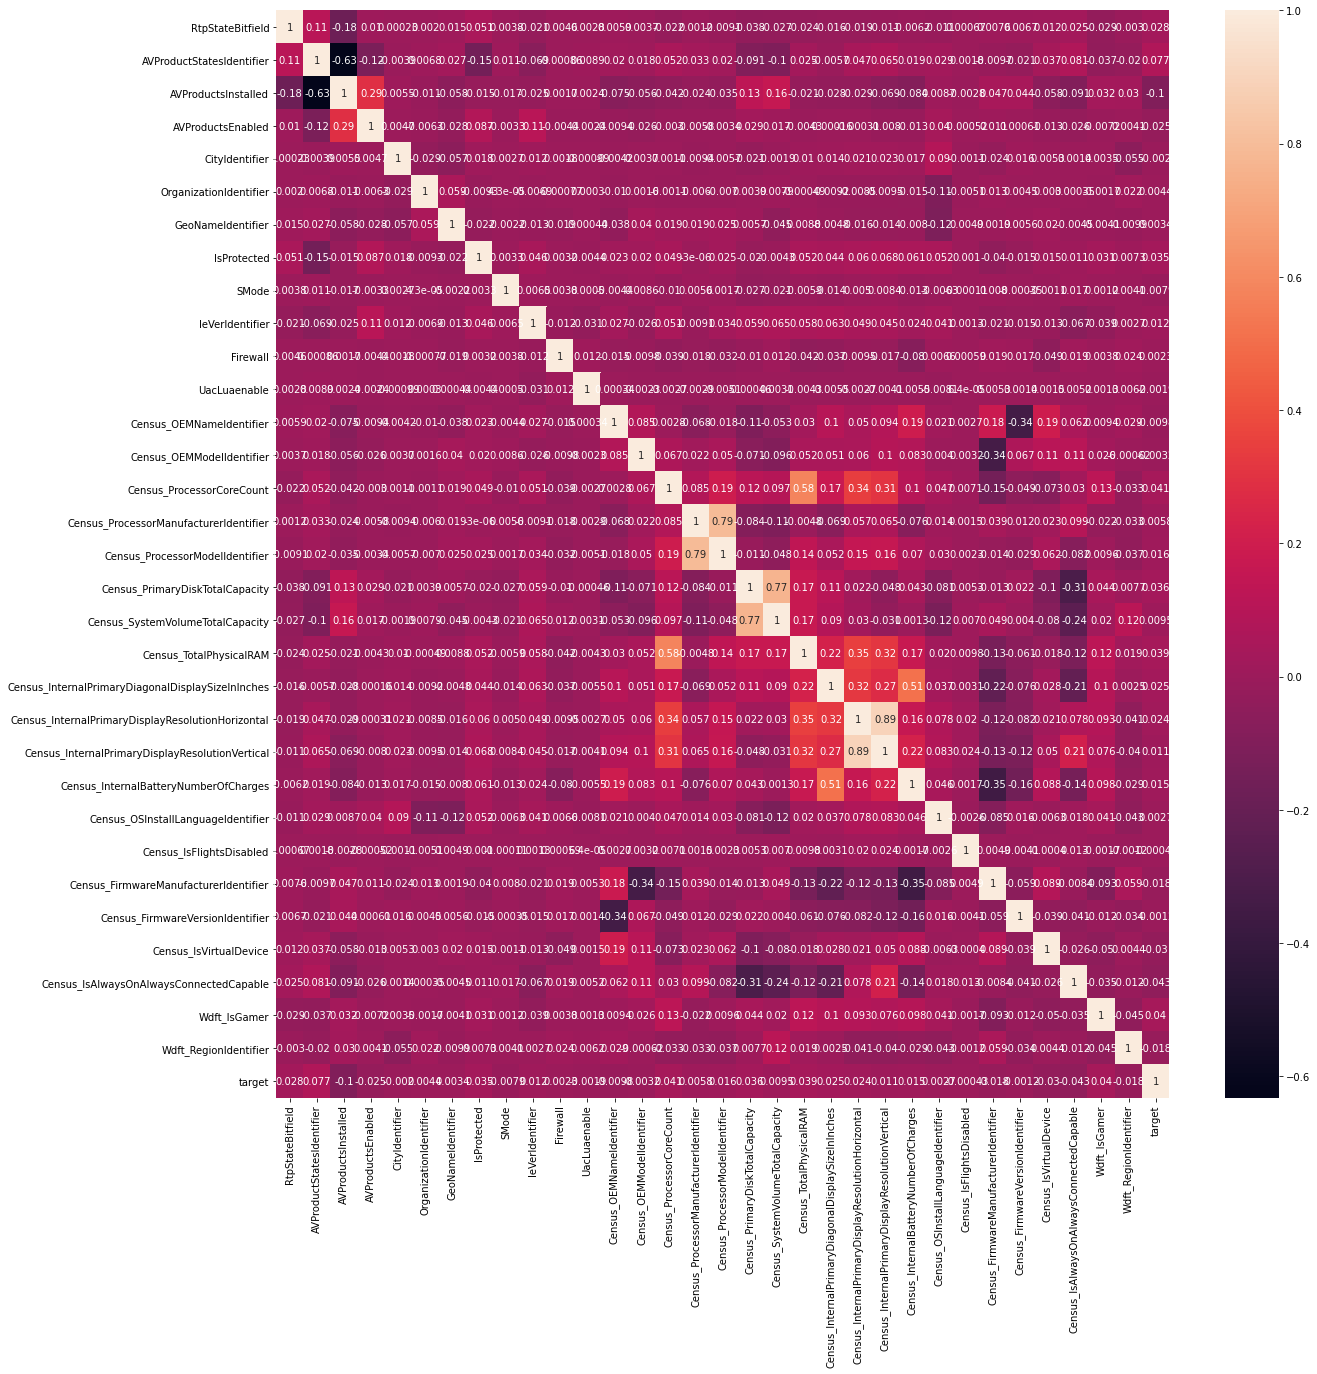

In [ ]:
floatdata['target']=malware.HasDetections
figure=plt.figure(figsize=(20,20))
corr=floatdata.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True)

In [ ]:
train=pd.concat([categoricalfreq,intdata,floatdata],join='outer',axis=1)
train.drop(['target','HasDetections'],inplace=True,axis=1)

In [ ]:
train.shape

(567730, 74)

In [ ]:
train.columns

Index(['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion',
       'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab',
       'SkuEdition', 'SmartScreen', 'Census_MDC2FormFactor',
       'Census_DeviceFamily', 'Census_PrimaryDiskTypeName',
       'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
       'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch',
       'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName',
       'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName',
       'Census_ActivationChannel', 'Census_FlightRing', 'IsBeta',
       'IsSxsPassiveMode', 'HasTpm', 'CountryIdentifier',
       'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'AutoSampleOptIn',
       'Census_HasOpticalDiskDrive', 'Census_OSBuildNumber',
       'Census_OSBuildRevision', 'Census_OSUILocaleIdentifier',
       'Census_IsPortableOperatingSystem', 'Census_IsSecureBootEnabled',
       'Census_IsTouchEnabled', 'Census_IsPenCapa

In [ ]:
logit = linear_model.LogisticRegression(C=.01,max_iter=3000,class_weight='balanced',penalty='l2')
# Recursively eliminate features
rfecv = RFECV(estimator=logit, step=1, scoring="roc_auc")
rfecv.fit(train, target)
rfecv.transform(train)

array([[1.        , 0.87274458, 0.07630093, ..., 0.        , 0.        ,
        0.64285714],
       [1.        , 1.        , 0.89882497, ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.87274458, 0.02975736, ..., 0.        , 0.        ,
        0.64285714],
       ...,
       [1.        , 0.06921737, 0.02533191, ..., 0.        , 1.        ,
        0.14285714],
       [1.        , 1.        , 0.98290859, ..., 1.        , 0.        ,
        1.        ],
       [1.        , 1.        , 0.13032199, ..., 0.        , 0.        ,
        0.64285714]])

In [ ]:
(rfecv.grid_scores_)*2-1

array([0.13805289, 0.14707456, 0.25922237, 0.27225922, 0.27538109,
       0.28469234, 0.2881861 , 0.28136582, 0.28170656, 0.28188556,
       0.28628266, 0.28726877, 0.29010921, 0.29335594, 0.3011818 ,
       0.30311054, 0.30424947, 0.30437131, 0.30405561, 0.30552136,
       0.3091411 , 0.31057892, 0.31106425, 0.31128057, 0.31330864,
       0.31358177, 0.31361962, 0.31418088, 0.31437575, 0.31438523,
       0.31443259, 0.31490201, 0.31490015, 0.31508455, 0.31546509,
       0.31564585, 0.31574965, 0.31576329, 0.31596438, 0.31624899,
       0.31633013, 0.31694088, 0.31736754, 0.31745837, 0.31758676,
       0.3178466 , 0.31803929, 0.31832149, 0.31861053, 0.31875125,
       0.31892504, 0.31901923, 0.31892948, 0.31893286, 0.31892032,
       0.31891071, 0.31891117, 0.31887811, 0.31888121, 0.31888379,
       0.31891492, 0.31888475, 0.31887541, 0.31889614, 0.31893068,
       0.31892335, 0.31890728, 0.31892423, 0.31891861, 0.3189264 ,
       0.31891184, 0.31891392, 0.31891169, 0.31891138])

In [ ]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 52


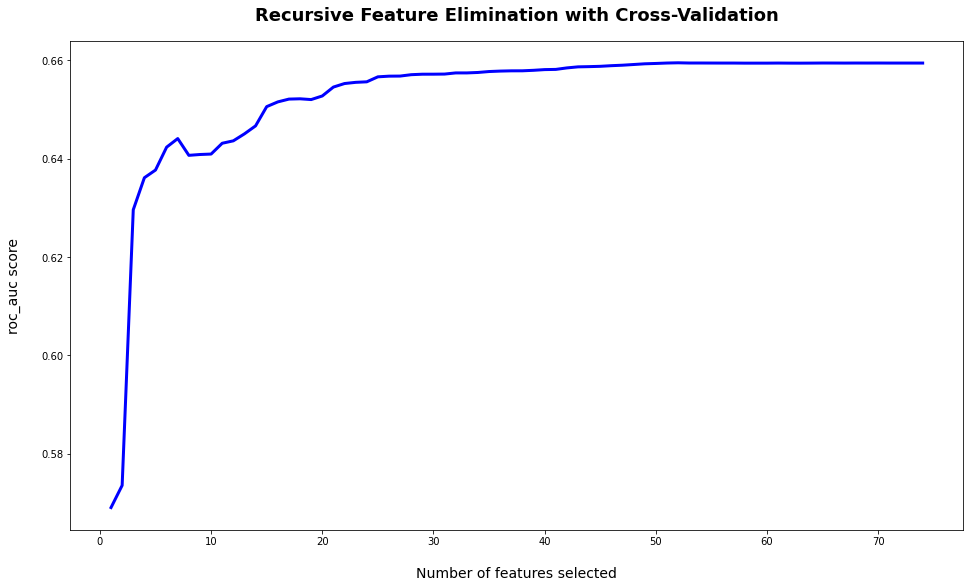

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('roc_auc score', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), (rfecv.grid_scores_), color='blue', linewidth=3)

plt.show()

In [ ]:
selected=train.columns[rfecv.get_support()]
selected

Index(['ProductName', 'EngineVersion', 'AvSigVersion', 'Platform', 'Processor',
       'OsVer', 'OsPlatformSubRelease', 'SkuEdition', 'SmartScreen',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName',
       'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSEdition',
       'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName',
       'Census_ActivationChannel', 'Census_FlightRing', 'IsSxsPassiveMode',
       'HasTpm', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite',
       'Census_HasOpticalDiskDrive', 'Census_OSBuildRevision',
       'Census_OSUILocaleIdentifier', 'Census_IsSecureBootEnabled',
       'Census_IsTouchEnabled', 'RtpStateBitfield',
       'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled',
       'OrganizationIdentifier', 'IsProtected', 'SMode', 'IeVerIdentifier',
       'Firewall', 'Census_ProcessorCoreCount',
       'Census_ProcessorModelIdentifier', 'Census_Primary

In [ ]:
select=['ProductName', 'EngineVersion', 'AvSigVersion', 'Platform', 'Processor',
       'OsVer', 'OsPlatformSubRelease', 'SkuEdition', 'SmartScreen',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName',
       'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSEdition',
       'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName',
       'Census_ActivationChannel', 'Census_FlightRing', 'IsSxsPassiveMode',
       'HasTpm', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite',
       'Census_HasOpticalDiskDrive', 'Census_OSBuildRevision',
       'Census_OSUILocaleIdentifier', 'Census_IsSecureBootEnabled',
       'Census_IsTouchEnabled', 'RtpStateBitfield',
       'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled',
       'OrganizationIdentifier', 'IsProtected', 'SMode', 'IeVerIdentifier',
       'Firewall', 'Census_ProcessorCoreCount',
       'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity',
       'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_InternalPrimaryDisplayResolutionHorizontal',
       'Census_OSInstallLanguageIdentifier',
       'Census_FirmwareManufacturerIdentifier', 'Census_IsVirtualDevice',
       'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer',
       'Wdft_RegionIdentifier']

In [ ]:
logit = linear_model.LogisticRegression(C=.01,max_iter=3000,class_weight='balanced',penalty='l2') #best .65
score=cross_val_score(logit,train.loc[:,select],target, scoring='roc_auc')

In [ ]:
score

array([0.65804928, 0.65775106, 0.66009517, 0.66043056, 0.66149188])

In [ ]:
modelogit=logit.fit(train,target)

In [ ]:
randomforest = RandomForestClassifier(n_estimators=3000, min_samples_leaf=200,max_leaf_nodes=600,random_state=0, n_jobs=-1,class_weight='balanced',oob_score=True) #best .6988

In [ ]:
randomforest.fit(train.loc[:,select],target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=600, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3000,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

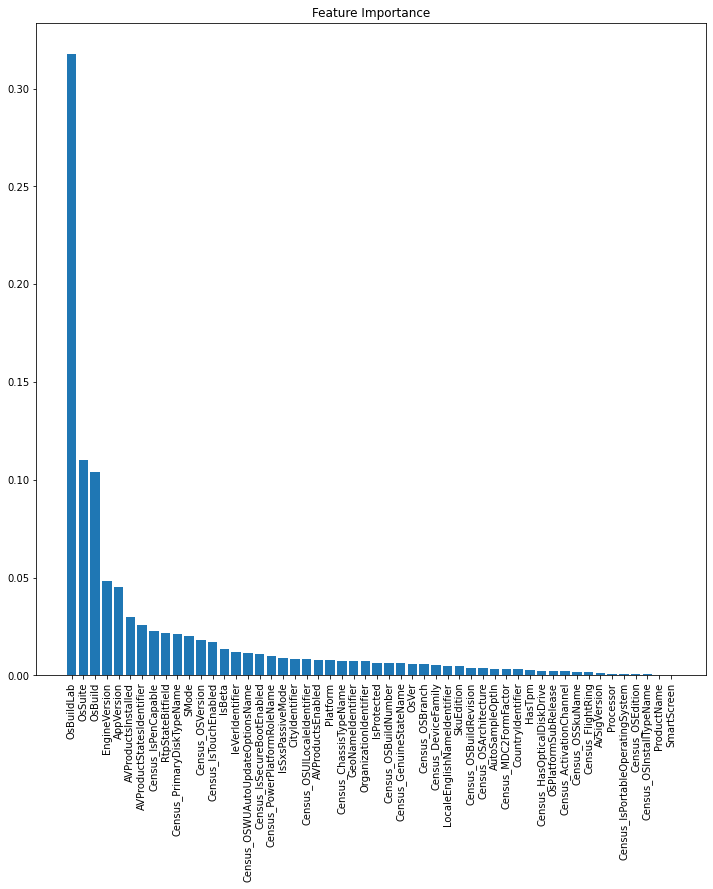

In [ ]:
importances = randomforest.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [train.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(12,12))
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(52), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(52), names, rotation=90)
# Show plot
plt.show()


In [ ]:
randomforest.oob_score_

0.6440843358638789

In [ ]:
clf_xgb=xgb.XGBClassifier(n_estimators=1200,learning_rate=0.01,max_depth=5,num_leaves=31,colsample_bytree=0.3,objective='binary:logistic',n_jobs=-1) #best .70165

In [ ]:
lg=lgb.LGBMClassifier(n_estimators=200,learning_rate=0.05,max_depth=5,num_leaves=31,colsample_bytree=0.3,objective='binary',n_jobs=-1)  #best .70040

In [ ]:
lg1=lgb.LGBMClassifier(n_estimators=1600,learning_rate=0.01,max_depth=5,num_leaves=31,colsample_bytree=0.3,objective='binary',n_jobs=-1) #best .70169 

In [ ]:
clf_xgb2=xgb.XGBClassifier(n_estimators=1400,learning_rate=0.01,max_depth=12,gamma=.9,subsample=.9,min_child_weight=50,colsample_bytree=0.3,objective='binary:logistic',n_jobs=-1) #best .71283

In [ ]:
clf_xgb1=xgb.XGBClassifier(n_estimators=1800,learning_rate=0.01,max_depth=12,gamma=.9,subsample=.9,min_child_weight=50,colsample_bytree=0.3,objective='binary:logistic',n_jobs=-1) #try

In [ ]:
lgb4=lgb.LGBMClassifier(n_estimators=9000,bagging_fraction=.9,learning_rate=.008,max_depth=20,lambda_l1=.8,colsample_bytree=0.3) #try

In [ ]:
score=cross_val_score(lg4,train,target,cv=2,scoring='roc_auc')

In [ ]:
score

array([0.71028753, 0.71289358])

In [ ]:
modelgb=lgb4.fit(train,target)

In [ ]:
testdata=pd.read_csv('/content/drive/My Drive/malware-detection-va/test_to_give.csv')
testdata

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,6810c5d22b0973b53a89ef881656e192,win8defender,1.1.14405.2,4.11.15063.1155,1.259.725.0,0,7.0,0,3000.0,7945.0,2.0,1.0,1,159,77866.0,27.0,194.0,75,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,NaN,108.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1443.0,256480.0,4.0,5.0,...,953869.0,HDD,239169.0,0,6144.0,Laptop,15.5,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.15063.1155,amd64,rs2_release,15063,1155,Core,CORE,Other,8.0,31,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,9321.0,1,NaN,0.0,0,0,0.0,0.0,11.0
1,4d810281c41ae85517e447146ec15b0a,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1232.0,0,7.0,0,NaN,7945.0,2.0,1.0,1,41,32657.0,27.0,52.0,217,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189457.0,2.0,5.0,...,476940.0,HDD,475950.0,0,4096.0,Notebook,15.5,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134,165,ProfessionalEducation,PROFESSIONAL,UUPUpgrade,9.0,34,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,0.0,556.0,63654.0,1,0.0,0.0,0,0,0.0,1.0,10.0
2,d0d7e4da90f95d04cdecc0143b690e0a,win8defender,1.1.15100.1,4.18.1807.18075,1.273.922.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,180,103309.0,NaN,233.0,210,windows10,x64,10.0.0.0,16299,256,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Pro,1.0,0,NaN,0.0,117.0,NaN,1.0,1.0,Desktop,Windows.Desktop,4589.0,313586.0,4.0,1.0,...,238475.0,SSD,237511.0,0,8192.0,Desktop,24.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.16299.547,amd64,rs3_release_svc_escrow,16299,547,Professional,PROFESSIONAL,Reset,30.0,128,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,9491.0,0,NaN,0.0,0,0,0.0,1.0,3.0
3,718b06bd3089b5a37c63ad6af86ee0cd,win8defender,1.1.15000.2,4.18.1806.18062,1.271.216.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,101,1873.0,27.0,129.0,126,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,0.0,117.0,RequireAdmin,1.0,1.0,AllInOne,Windows.Desktop,525.0,318973.0,2.0,5.0,...,953869.0,HDD,153600.0,0,4096.0,Desktop,19.4,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.16299.371,amd64,rs3_release,16299,371,Core,CORE,Update,19.0,74,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,142.0,2827.0,1,0.0

In [ ]:
machineid=testdata['MachineIdentifier']
testdata.drop(['DefaultBrowsersIdentifier','MachineIdentifier','PuaMode','Census_ProcessorClass','Census_InternalBatteryType','Census_IsFlightingInternal','Census_ThresholdOptIn',
'Census_IsWIMBootEnabled'],axis=1,inplace=True)

In [ ]:
catdatat=selectbytype(testdata,'object')
catdatat=labelencode(catdatat.copy(),catdatat.columns)
catdatatfreq=frequencyencoding(catdatat.copy(),catdatat.columns)
catdatatfreq

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
0,1.0,0.010982,0.010297,0.001391,1.0,1.0,1.0,0.205182,0.207520,1.000000,0.697655,1.000000,1.0,1.000000,0.131256,1.000000,0.034385,1.0,0.210476,1.000000,1.000000,0.327245,0.536733,1.0,0.713072,1.0
1,1.0,0.874704,1.000000,0.061217,1.0,1.0,1.0,1.000000,1.000000,0.569401,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.603154,1.0,1.000000,0.014965,0.873406,1.000000,1.000000,1.0,1.000000,1.0
2,1.0,0.874704,1.000000,0.066087,1.0,1.0,1.0,0.663114,0.345209,0.569401,0.697655,0.332289,1.0,0.429988,0.345421,0.324892,0.245895,1.0,0.298941,0.858125,0.873406,0.251117,0.653113,1.0,1.000000,1.0
3,1.0,0.083533,0.177617,0.008000,1.0,1.0,1.0,0.663114,0.279669,1.000000,1.000000,0.050069,1.0,1.000000,0.345421,0.324892,0.255758,1.0,0.336079,1.000000,1.000000,0.651612,0.653113,1.0,0.713072,1.0
4,1.0,1.000000,1.000000,0.106783,1.0,1.0,1.0,1.000000,1.000000,0.569401,0.697655,0.332289,1.0,0.064937,0.345421,0.324892,1.000000,1.0,1.000000,0.858125,0.873406,0.000000,1.000000,1.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243308,1.0,1.000000,1.000000,0.179826,1.0,1.0,1.0,0.663114,0.279669,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.120387,1.0,0.336079,1.000000,1.000000,0.651612,0.536733,1.0,1.000000,1.0
243309,1.0,0.083533,0.177617,0.114435,1.0,1.0,1.0,0.196607,0.055025,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.168780,1.0,0.211843,0.520147,0.520138,0.651612,0.536733,1.0,0.713072,1.0
243310,1.0,1.000000,0.027681,0.910261,1.0,1.0,1.0,0.663114,0.279669,1.000000,0.697655,1.000000,1.0,1.000000,1.000000,1.000000,0.120387,1.0,0.336079,0.520147,0.520138,1.000000,0.653113,1.0,1.000000,1.0
243311,1.0,1.000000,1.000000,0.323478,1.0,1.0,1.0,0.663114,0.345209,1.000000,1.000000,0.050069,1.0,1.000000,0.345421,0.324892,0.401236,1.0,0.298941,1.000000,1.000000,0.508772,0.653113,1.0,0.713072,1.0


In [ ]:
intdatat=selectbytype(testdata,'int64')
intdatat=scale(intdatat.copy(),intdatat.columns)
intdatat

,IsBeta,IsSxsPassiveMode,HasTpm,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,AutoSampleOptIn,Census_HasOpticalDiskDrive,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable
0,0,0,1,0.714932,0.262411,0.701278,0.979167,0,0,0.632145,0.060465,0.166667,0,1,0,0
1,0,0,1,0.180995,0.765957,0.895884,0.312500,0,0,0.871789,0.008638,0.185897,0,1,0,0
2,0,0,1,0.809955,0.741135,0.817422,0.312500,0,0,0.775168,0.028636,0.788462,0,0,0,0
3,0,0,1,0.452489,0.443262,0.817422,0.979167,0,0,0.775168,0.019422,0.442308,0,1,0,0
4,0,0,1,0.190045,0.145390,0.895884,0.312500,0,0,0.871789,0.011936,0.980769,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243308,0,0,1,0.221719,0.177305,0.817422,0.979167,0,0,0.775168,0.016176,0.096154,0,1,0,0
243309,0,0,1,0.253394,0.783688,0.638320,0.979167,0,0,0.554617,0.114595,0.192308,0,1,0,0
243310,0,0,1,0.633484,0.801418,0.817422,0.979167,0,0,0.775168,0.016176,0.185897,0,0,0,0
243311,0,0,1,0.918552,0.258865,0.817422,0.979167,0,1,0.775168,0.022563,0.166667,0,1,1,0


In [ ]:
floatdatat=selectbytype(testdata,'float64')
floatdatat.fillna(floatdatat.mean(),inplace=True)
floatdatat=scale(floatdatat.copy(),floatdatat.columns)
floatdatat

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSInstallLanguageIdentifier,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,0.875,0.112226,0.25,0.2,0.463595,0.509804,0.654237,1.0,0.000634,0.250000,1.0,0.020833,0.228928,0.742348,0.031579,0.444444,0.537391,0.100012,0.025078,0.010753,0.104742,0.132448,0.200208,0.000000,0.184211,0.000000,0.320896,0.128972,0.0,0.000000,0.0,0.714286
1,0.875,0.112226,0.25,0.2,0.194408,0.509804,0.172881,1.0,0.000000,0.317757,1.0,0.020833,0.088226,0.548358,0.010526,0.444444,0.451830,0.050007,0.049906,0.006843,0.104742,0.132448,0.200208,0.000000,0.210526,0.000000,0.508396,0.882948,0.0,0.000000,1.0,0.642857
2,0.875,0.758130,0.00,0.2,0.615091,0.467755,0.786441,1.0,0.000000,0.271028,1.0,0.020833,0.744834,0.907635,0.031579,0.000000,0.239389,0.025004,0.024904,0.014663,0.164897,0.186125,0.281437,1.000000,0.763158,0.000000,0.122201,0.131331,0.0,0.000000,1.0,0.142857
3,0.875,0.758130,0.00,0.2,0.011111,0.509804,0.433898,1.0,0.000000,0.271028,1.0,0.020833,0.078386,0.923227,0.010526,0.444444,0.443072,0.100012,0.016106,0.006843,0.132343,0.186125,0.281437,1.000000,0.473684,0.000000,0.122201,0.038855,0.0,0.000000,0.0,0.571429
4,0.875,0.758130,0.00,0.2,0.856245,0.333333,0.176271,1.0,0.000000,0.317757,1.0,0.020833,0.429813,0.741523,0.030636,0.391523,0.525309,0.052434,0.039172,0.010323,0.157820,0.186125,0.281437,0.255888,0.947368,0.000013,0.369233,0.458044,0.0,0.066615,0.0,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243308,0.875,0.758130,0.00,0.2,0.686435,0.467755,0.227119,1.0,0.000000,0.257009,1.0,0.020833,0.354051,0.579455,0.031579,0.444444,0.509544,0.050007,0.048250,0.006843,0.104742,0.132448,0.200208,0.000000,0.052632,0.000000,0.506530,0.459563,0.0,0.000000,1.0,0.142857
243309,0.875,0.867730,0.25,0.2,0.336090,0.333333,0.254237,0.0,0.000000,0.226636,1.0,0.020833,0.336996,0.701858,0.010526,0.444444,0.444419,0.050007,0.048106,0.006843,0.093418,0.132448,0.200208,0.000000,0.236842,0.000000,0.506530,0.458314,0.0,0.000000,0.0,0.642857
243310,0.875,0.758130,0.00,0.2,0.571898,0.921569,0.562712,1.0,0.000000,0.257009,1.0,0.020833,0.728600,0.890511,0.031579,0.444444,0.514485,0.075009,0.074867,0.010753,0.093418,0.132448,0.200208,0.000000,0.210526,0.000000,0.508396,0.792609,0.0,0.000000,0.0,0.642857
243311,0.875,0.758130,0.00,0.2,0.483292,0.509804,0.867797,1.0,0.000000,0.271028,1.0,0.020833,0.336996,0.291186,0.031579,0.444444,0.581406,0.100012,0.098613,0.010753,0.157820,0.186125,0.281437,1.000000,0.184211,0.000000,0.076493,0.274416,0.0,0.000000,0.0,0.714286


In [ ]:
test=pd.concat([catdatatfreq,intdatat,floatdatat],join='outer',axis=1)
test

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,IsBeta,IsSxsPassiveMode,HasTpm,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,AutoSampleOptIn,Census_HasOpticalDiskDrive,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSInstallLanguageIdentifier,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,1.0,0.010982,0.010297,0.001391,1.0,1.0,1.0,0.205182,0.207520,1.000000,0.697655,1.000000,1.0,1.000000,0.131256,1.000000,0.034385,1.0,0.210476,1.000000,1.000000,0.327245,0.536733,1.0,0.713072,1.0,0,0,1,0.714932,0.262411,0.701278,0.979167,0,0,0.632145,0.060465,0.166667,0,1,0,0,0.875,0.112226,0.25,0.2,0.463595,0.509804,0.654237,1.0,0.000634,0.250000,1.0,0.020833,0.228928,0.742348,0.031579,0.444444,0.537391,0.100012,0.025078,0.010753,0.104742,0.132448,0.200208,0.000000,0.184211,0.000000,0.320896,0.128972,0.0,0.000000,0.0,0.714286
1,1.0,0.874704,1.000000,0.061217,1.0,1.0,1.0,1.000000,1.000000,0.569401,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.603154,1.0,1.000000,0.014965,0.873406,1.000000,1.000000,1.0,1.000000,1.0,0,0,1,0.180995,0.765957,0.895884,0.312500,0,0,0.871789,0.008638,0.185897,0,1,0,0,0.875,0.112226,0.25,0.2,0.194408,0.509804,0.172881,1.0,0.000000,0.317757,1.0,0.020833,0.088226,0.548358,0.010526,0.444444,0.451830,0.050007,0.049906,0.006843,0.104742,0.132448,0.200208,0.000000,0.210526,0.000000,0.508396,0.882948,0.0,0.000000,1.0,0.642857
2,1.0,0.874704,1.000000,0.066087,1.0,1.0,1.0,0.663114,0.345209,0.569401,0.697655,0.332289,1.0,0.429988,0.345421,0.324892,0.245895,1.0,0.298941,0.858125,0.873406,0.251117,0.653113,1.0,1.000000,1.0,0,0,1,0.809955,0.741135,0.817422,0.312500,0,0,0.775168,0.028636,0.788462,0,0,0,0,0.875,0.758130,0.00,0.2,0.615091,0.467755,0.786441,1.0,0.000000,0.271028,1.0,0.020833,0.744834,0.907635,0.031579,0.000000,0.239389,0.025004,0.024904,0.014663,0.164897,0.186125,0.281437,1.000000,0.763158,0.000000,0.122201,0.131331,0.0,0.000000,1.0,0.142857
3,1.0,0.083533,0.177617,0.008000,1.0,1.0,1.0,0.663114,0.279669,1.000000,1.000000,0.050069,1.0,1.000000,0.345421,0.324892,0.255758,1.0,0.336079,1.000000,1.000000,0.651612,0.653113,1.0,0.713072,1.0,0,0,1,0.452489,0.443262,0.817422,0.979167,0,0,0.775168,0.019422,0.442308,0,1,0,0,0.875,0.758130,0.00,0.2,0.011111,0.509804,0.433898,1.0,0.000000,0.271028,1.0,0.020833,0.078386,0.923227,0.010526,0.444444,0.443072,0.100012,0.016106,0.006843,0.132343,0.186125,0.281437,1.000000,0.473684,0.000000,0.122201,0.038855,0.0,0.000000,0.0,0.571429
4,1.0,1.000000,1.000000,0.106783,1.0,1.0,1.0,1.000000,1.000000,0.569401,0.697655,0.332289,1.0,0.064937,0.345421,0.324892,1.000000,1.0,1.000000,0.858125,0.873406,0.000000,1.000000,1.0,1.000000,1.0,0,0,1,0.190045,0.145390,0.895884,0.312500,0,0,0.871

In [ ]:
prediction=pd.DataFrame(modelgb.predict_proba(test))
prediction

,0,1
0,0.957187,0.042813
1,0.920099,0.079901
2,0.768472,0.231528
3,0.952040,0.047960
4,0.880088,0.119912
...,...,...
243308,0.804105,0.195895
243309,0.914944,0.085056
243310,0.815806,0.184194
243311,0.915402,0.084598


In [ ]:
pre=pd.DataFrame()
pre['MachineIdentifier']=machineid
pre['HasDetections']=prediction.loc[:,1]
pre

,MachineIdentifier,HasDetections
0,6810c5d22b0973b53a89ef881656e192,0.042813
1,4d810281c41ae85517e447146ec15b0a,0.079901
2,d0d7e4da90f95d04cdecc0143b690e0a,0.231528
3,718b06bd3089b5a37c63ad6af86ee0cd,0.047960
4,4ab7e3633628cccb65e055d91979c31b,0.119912
...,...,...
243308,5426568056581385156f6c57eb1c16b7,0.195895
243309,4d05c57f5fa2177e4463b1d93adb9282,0.085056
243310,6aa49e8161838cca6b0584a18c45f016,0.184194
243311,690d6524746bb857e27876471a649176,0.084598


In [ ]:
pre.to_csv('pre.csv',index=False)